## Setup

In [6]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn 
import tqdm

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import warnings
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, multilabel_confusion_matrix

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
https://www.youtube.com/watch?v=vNKIg8rXK6w&ab_channel=rupertai


In [7]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [9]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Jul  3 19:41:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
|  0%   45C    P8    29W / 450W |      1MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [10]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

In [11]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Load Dataset

In [12]:
## load data (takes around 1min15s)
df_train = pd.read_pickle(os.path.join(data_path, "train_dataset_for_DL.pkl"))
print("Train dataset: ", df_train.shape)
df_test = pd.read_pickle(os.path.join(data_path, "test_dataset_for_DL.pkl"))
print("Test dataset: ", df_test.shape)
df_valid100 = pd.read_pickle(os.path.join(data_path, "valid100_dataset_for_DL.pkl"))
print("Validation dataset: ", df_valid100.shape)

Train dataset:  (125264, 103022)
Test dataset:  (29244, 103022)
Validation dataset:  (100, 103022)


: 

In [11]:
df_train.columns

Index(['!Xóõ (langue)', '"Sprach- und Sachatlas Italiens und der Südschweiz"',
       '"Taalatlas van Noord- en Zuid-Nederland"', ''?d', ''?ntokyo',
       ''Are'are (peuple des îles Salomon)', ''Au keto',
       ''Au keto, Musique d'', ''Au ni aau', ''Au ni aau, Musique d'',
       ...
       'évangéliaire de split', 'Ālāp', 'Ārbajo, Musique d'',
       'Đinh pơng, Musique de', 'Ō-tsuzumi, Musique d'', 'ʿArūbi', 'Ḥawfi',
       'Ṭhumrī', 'Ṭār (tambour), Musique de', 'descr'],
      dtype='object', length=103022)

In [16]:
# Get labels
labels_list  = df_train.columns[:-1]
print(f"There are {len(labels_list )} labels")

There are 103021 labels


## Build the model

In [ ]:
# Build Deep Learning Model with CamemBERT/PyTorch
from transformers import  AutoTokenizer
MODEL_NAME = 'camembert-base'
camembert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Camembert tokenizer
camembert_input = camembert_tokenizer(text_example, padding='max_length', max_length=20, truncation=True, return_tensors="pt")
print(camembert_input['input_ids'])
print(camembert_input["input_ids"].shape, bert_input["attention_mask"].shape)
print(camembert_input['attention_mask'])
print(camembert_tokenizer.decode(camembert_input.input_ids[0]))

In [14]:
# Build Deep Learning Model with CamemBERT/PyTorch
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
MODEL_NAME = 'camembert-base'
camembert = CamembertForMaskedLM.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [21]:
# remove any unwanted garbage using the collector
import gc
gc.collect()

# import fastbert's main classes
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner
from fast_bert.prediction import BertClassificationPredictor


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1086, in _get_module
  File "/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/transformers/trainer.py", line 37, in <module>
    from .integrations import (  # isort: split
  File "/home/aurelie/anaconda3/envs/abes

In [24]:
# Create databuncj and learner for test classificaiton
databunch = BertDataBunch(data_path, 
                          data_path,
                          tokenizer='camembert-base',
                          train_file='train_dataset_for_DL.csv',
                          val_file='test_dataset_for_DL.csv',
                          label_file='labels.txt',
                          text_col='desc',
                          label_col= labels_list,
                          batch_size_per_gpu=14,    
                          max_seq_length=512,
                          multi_gpu=False,
                          multi_label=True,
                          model_type='camembert-base')

FileNotFoundError: [Errno 2] No such file or directory: 'data/labels.txt'

: 

#### Tokenization example

In [15]:
# Simple tokenizer
text_example = 'Je regarderai la serie à la télévision avec mes enfants ce soir'
tokenizer_output = tokenizer(text_example, padding='max_length', max_length=20, truncation=True, return_tensors="pt")
print(tokenizer_output['input_ids'])
print(tokenizer_output["input_ids"].shape, tokenizer_output["attention_mask"].shape)
print(tokenizer_output['attention_mask'])
print(tokenizer.decode(tokenizer_output.input_ids[0]))

tensor([[   5,  100, 1483,   73,   13,   48,  915,   15,   13, 2572,   42,  249,
          329,   44,  619,    6,    1,    1,    1,    1]])
torch.Size([1, 20]) torch.Size([1, 20])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
<s> Je regarderai la serie à la télévision avec mes enfants ce soir</s><pad><pad><pad><pad>


In [40]:
# Tokenisation de batches
def tokenize_batch(samples, tokenizer):
    text = [sample["descr"] for sample in samples]
    labels = torch.tensor([sample[mlb.classes_] for sample in samples])
    str_labels = [sample[mlb.classes_] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [41]:
import functools
val_dataloader = DataLoader(df_valid100, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), batch_size=16)
next(iter(val_dataloader))

KeyError: 0

In [20]:
# Initialisation du model
with torch.no_grad():
    model_output = camembert(**tokenizer_output, output_hidden_states=True)
    model_output

In [21]:
# Check shape
model_output.logits.shape

torch.Size([1, 20, 32005])

In [32]:
sample_descr.values

array(["La bataille mondiale des matières premières Dans le débat sur un nouvel ordre économique international, les marchés mondiaux des matières premières constituent un enjeu de première importance. Ils conditionnent largement les moyens de financement du développement de pays pauvres et sont un des lieux stratégiques où se joue l'indépendance des pays. L'auteur analyse d'abord les mécanismes et les acteurs des marchés libres, mettant en lumière les limites du jeu libéral de l'offre et de la demande. Son examen des divers systèmes de régulation qui ont été expérimentés l'amènent ensuite à émettre de sérieuses réserves sur l'efficacité des stocks régulateurs. De même, les accords compensatoires (type prêts du FMI) se heurtent-ils à des difficultés théoriques et concrètes de mise en place. La régulation de l'offre n'a véritablement réussi que dans le cas du pétrole. Des solutions plus radicales existent en dehors d'un fonctionnement aménagé du marché : ouverture unilatérale des frontiè

In [30]:
tokenizer_output = tokenizer(sample_descr, padding='max_length', max_length=20, truncation=True, return_tensors="pt")


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [23]:
def get_probas_from_logits(logits):
    return logits.softmax(-1)


def visualize_mlm_predictions(tokenizer_output, model_output, tokenizer, nb_candidates=10):
    # Decode the tokenized sentences and clean-up the special tokens
    decoded_tokenized_sents = [sent.replace('<pad>', '').replace('<mask>', ' <mask>') for sent in tokenizer.batch_decode(tokenizer_output.input_ids)]

    # Retrieve the probas at the masked positions
    masked_tokens_mask = tokenizer_output.input_ids == tokenizer.mask_token_id
    batch_mask_probas = get_probas_from_logits(model_output.logits[masked_tokens_mask])

    for sentence, mask_probas in zip(decoded_tokenized_sents, batch_mask_probas):
        # Get top probas and plot them
        top_probas, top_token_ids = mask_probas.topk(nb_candidates, -1)
        top_tokens = tokenizer.convert_ids_to_tokens(top_token_ids)
        bar_chart = px.bar({"tokens": top_tokens[::-1], "probas": list(top_probas)[::-1]},
                        x="probas", y="tokens", orientation='h', title=sentence, width=800)
        bar_chart.show(config={'staticPlot': True})

visualize_mlm_predictions(tokenizer_output, model_output, tokenizer)

In [166]:
# Camembert tokenizer
camembert_input = camembert_tokenizer(text_example, padding='max_length', max_length=20, truncation=True, return_tensors="pt")
print(camembert_input['input_ids'])
print(camembert_input["input_ids"].shape, bert_input["attention_mask"].shape)
print(camembert_input['attention_mask'])
print(camembert_tokenizer.decode(camembert_input.input_ids[0]))

tensor([[   5,  100, 1483,   73,   13,   48,  915,   15,   13, 2572,   42,  249,
          329,   44,  619,    6,    1,    1,    1,    1]])
torch.Size([1, 20]) torch.Size([1, 20])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
<s> Je regarderai la serie à la télévision avec mes enfants ce soir</s><pad><pad><pad><pad>


In [187]:
# More complex tokenizerr
encoding = tokenizer.encode_plus(
    text_example,
    add_special_tokens=True,
    max_length=20,
    truncation=True,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
    return_tensors="pt"
)

# Check model
print(encoding.keys())
# Check shapes
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)
# Check contents of encoding outputs
print(encoding["input_ids"])
print(encoding["attention_mask"])
# Inverse tokenization to get back words
print(tokenizer.convert_ids_to_tokens(encoding.input_ids[0]))

dict_keys(['input_ids', 'attention_mask'])
torch.Size([1, 20]) torch.Size([1, 20])
tensor([[  101, 13796, 42047, 12015, 10116, 10109, 11185,   254, 10109, 33110,
         10460, 17954, 18374, 10794, 50520,   102,     0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
['[CLS]', 'Je', 'regard', '##era', '##i', 'la', 'serie', 'à', 'la', 'télévision', 'avec', 'mes', 'enfants', 'ce', 'soir', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [191]:
# Number of tokens by description
token_counts = []
df_train_sample = df_train.sample(n=20000, random_state=42)
for _, row in df_train_sample.iterrows():
  token_count = len(tokenizer.encode(
    row["descr"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

(0.0, 512.0)

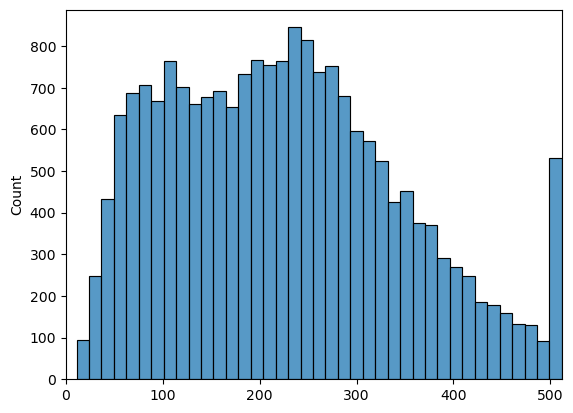

In [193]:
# Histplot
sns.histplot(token_counts)
plt.xlim([0, 512])

Most of the comments contain less than 300 tokens or more than 512. So, we’ll stick with the limit of 512.

In [194]:
MAX_TOKEN_COUNT = 512

In [195]:
class RameauLabelDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: tokenizer, max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        descr = data_row.descr
        labels = data_row[mlb.classes_]

        encoding = self.tokenizer.encode_plus(
            descr,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return dict(
            descr = descr,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [197]:
# Check on an item from the dataset
train_dataset = RameauLabelDataset(
  df_train_sample,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['descr', 'input_ids', 'attention_mask', 'labels'])

In [198]:
print("Description: ", sample_item["descr"])
print("Labels: ", sample_item["labels"])
print("Shape: ", sample_item["input_ids"].shape)

Description:  Les réseaux de symptômes en psychopathologie : enjeux théoriques, méthodologiques et sémiologiques Les débats contemporains sur les classifications psychiatriques illustrent la complexité des troubles psychiatriques. Ces tensions ne sont pas seulement cliniques mais relèvent de défis théoriques, méthodologiques et épistémologiques. L'un de ces débats concerne une tendance récente à s'éloigner des catégories diagnostiques conventionnelles pour se concentrer sur les symptômes individuels. L'accent est mis sur la forme et la structure des relations entre les éléments sémiologiques. Parmi les nombreux modèles promettant d'améliorer notre compréhension des troubles psychologiques, les réseaux de symptômes en psychopathologie proposent de concevoir le trouble psychiatrique comme une propriété émergente résultant d'interactions entre symptômes. Ces interactions s'alignent sur la manière dont les cliniciens perçoivent les symptômes de leur patient en tant que réseaux de problèmes

In [200]:
# Load pretrained model and pass a sample of batch data
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
print(output.last_hidden_state.shape, output.pooler_output.shape)


TypeError: BertModel.__init__() got an unexpected keyword argument 'return_dict'

In [82]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0), sample_item["attention_mask"].unsqueeze(dim=0))
prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 512, 768]), torch.Size([1, 768]))

In [178]:
class RameauLabelDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, val_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = RameauLabelDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = RameauLabelDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

        self.val_dataset = RameauLabelDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )

In [179]:
N_EPOCHS = 10
BATCH_SIZE = 12

In [180]:
data_module = RameauLabelDataModule(
    df_train, 
    df_test, 
    df_valid100, 
    camembert_tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len = MAX_TOKEN_COUNT)

In [181]:
data_module.setup()

In [182]:
# Model
class RameauLabelTagger(pl.LightningModule):
  
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModcel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    self.training_step_outputs = []
  
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.training_step_outputs.append(loss)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}
  
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  

  def on_train_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(mlb.classes_):
      class_roc_auc = torchmetrics.AUROC(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
      
    # epoch_average = torch.stack(self.training_step_outputs).mean()
    # self.log("training_epoch_average", epoch_average)
    # self.training_step_outputs.clear()

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [183]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [184]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(20876, 104380)

In [185]:
# Instance of the current model
model = RameauLabelTagger(
  n_classes=len(mlb.classes_),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

100%|██████████| 662804195/662804195 [01:19<00:00, 8349284.22B/s]


TypeError: BertModel.__init__() got an unexpected keyword argument 'return_dict'

In [104]:
# Evaluation
criterion = nn.BCELoss()

_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5104, 0.4966, 0.4723,  ..., 0.4466, 0.5906, 0.3160],
        [0.5355, 0.5175, 0.4515,  ..., 0.4375, 0.5990, 0.3143],
        [0.5286, 0.5136, 0.4514,  ..., 0.4386, 0.5988, 0.3228],
        ...,
        [0.5371, 0.5350, 0.4555,  ..., 0.4332, 0.5988, 0.3072],
        [0.5555, 0.5151, 0.4443,  ..., 0.4443, 0.5990, 0.3247],
        [0.5502, 0.5014, 0.4363,  ..., 0.4384, 0.6002, 0.3204]],
       grad_fn=<SigmoidBackward0>)

In [116]:
criterion(predictions, sample_batch["labels"])

tensor(0.7168, grad_fn=<BinaryCrossEntropyBackward0>)

## Training

In [106]:
checkpoint_callback = ModelCheckpoint(
  dirpath="./checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [107]:
# Log the progress in Tensorboard
logger = TensorBoardLogger("lightning_logs", name="Rameau")

In [108]:
# Add early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [109]:
# Training
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  devices=1,
  accelerator="gpu",
  enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [110]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["require_grad"] = "True"

In [111]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 79.2 M
2 | criterion  | BCELoss   | 0     
-----------------------------------------
187 M     Trainable params
0         Non-trainable params
187 M     Total params
750.134   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/10439 [00:00<?, ?it/s] 

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
trainer.test()

In [ ]:
# Predictions
trained_model = RameauLabelTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(mlb.classes_)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
# Evaluation
MAX_TOKEN_COUNT = 512


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = RameauLabelDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

## Metrics

In [ ]:
# Accuracy
THRESHOLD = 0.7
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
# AUROC
print("AUROC per tag")
for i, name in enumerate(mlb.classes_):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
# Classification report
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=mlb.classes_,
  zero_division=0
))